# Análisis exploratorio de datos (EDA) para el dataset de calidad del sueño

In [29]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
import hdbscan
import pandas as pd

# Evitar warnings de OpenMP
import os
os.environ["OMP_NUM_THREADS"] = "2"

## Preparacion de los datos

In [30]:
# Cargo los datos de entrenamiento
df = pd.read_csv('data/train.csv')
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Female,37,Lawyer,8.4,8,75,5,Normal,130/85,72,8000,Insomnia
1,Female,44,Doctor,7.2,8,55,7,Normal,115/75,70,5000,NaN
2,Female,37,Lawyer,8.0,8,60,5,Overweight,140/95,72,3000,Insomnia
3,Female,57,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,NaN
4,Female,45,Teacher,6.5,7,45,4,Overweight,135/90,65,6000,Insomnia
...,...,...,...,...,...,...,...,...,...,...,...,...
442,Male,32,Doctor,6.0,6,30,8,Normal,125/80,72,5000,NaN
443,Male,48,Nurse,7.8,9,45,6,Normal,125/80,75,10000,NaN
444,Male,35,Teacher,6.7,7,40,5,Overweight,128/84,70,5600,NaN
445,Male,29,Doctor,6.0,6,30,8,Normal,120/80,70,8000,NaN


In [31]:
def get_X_y(df: pd.DataFrame):
    """Preprocesa los datos y construye X, y para el modelado."""
    print("Preparando features y variable objetivo...")
    df = df.copy()

    # Procesamiento de presión arterial si existe
    if 'Blood Pressure' in df.columns:
        bp_split = df['Blood Pressure'].str.split('/', expand=True)
        df['BP_sys'] = pd.to_numeric(bp_split[0], errors='coerce')
        df['BP_dia'] = pd.to_numeric(bp_split[1], errors='coerce')
        df.drop(columns=['Blood Pressure'], inplace=True)

        # Features adicionales derivados de BP
        df['BP_mean'] = (df['BP_sys'] + df['BP_dia']) / 2
        df['high_bp'] = ((df['BP_sys'] >= 130) | (df['BP_dia'] >= 80)).astype(int)

    # Manejo de valores faltantes para Sleep Disorder
    df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

    # Definición de variable objetivo: calidad de sueño buena (≥7)
    df['target'] = (df['Quality of Sleep'] >= 7).astype(int)

    # Eliminar columna original de calidad para evitar data leakage
    df.drop(columns=['Quality of Sleep'], inplace=True)

    # Dividir en características y target
    X = df.drop(columns=['target'])
    y = df['target']

    print(f"Datos preparados: {X.shape[0]} registros, {X.shape[1]} características")

    return X, y

X, y = get_X_y(df)

Preparando features y variable objetivo...
Datos preparados: 447 registros, 14 características


## Visualización de la distribución de la variable objetivo

### T-SNE y PCA

Aplicando t-SNE...


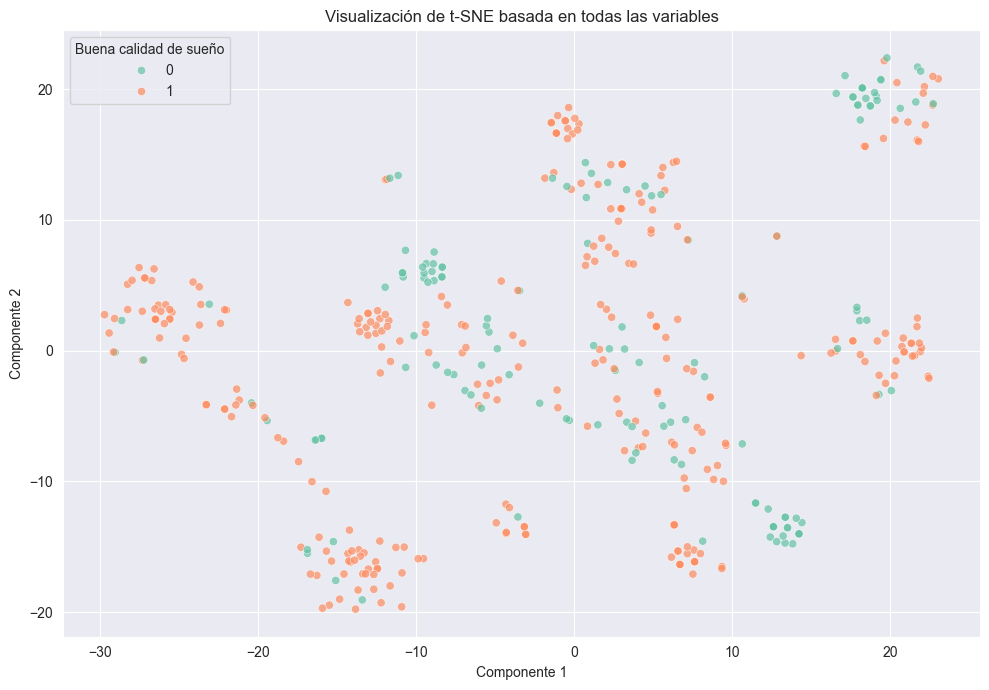

In [32]:
def tsne_visualization(X,y):
    # One-hot encoding para variables categóricas automáticamente
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Escalado de características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # t-SNE
    print("Aplicando t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    # Visualización
    tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
    tsne_df['target'] = y.values

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='target', palette='Set2', alpha=0.7)
    plt.title('Visualización de t-SNE basada en todas las variables')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid(True)
    plt.legend(title='Buena calidad de sueño')
    plt.tight_layout()
    plt.show()

tsne_visualization(X, y)

Aplicando PCA...


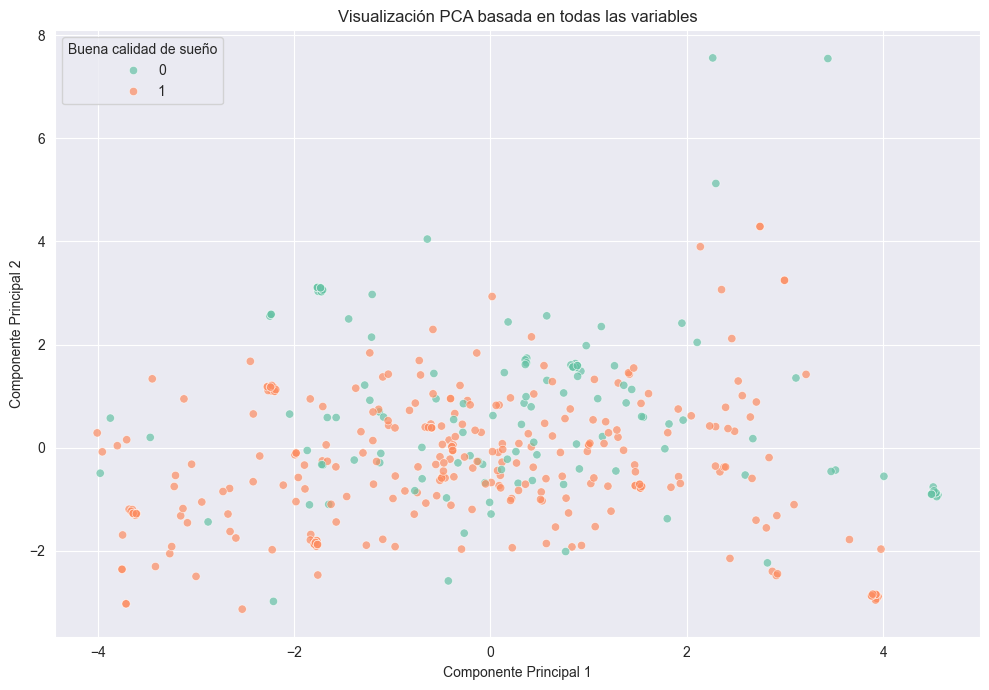

In [33]:
def pca_visualization(X, y):
    # One-hot encoding para variables categóricas automáticamente
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Escalado de características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # PCA
    print("Aplicando PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Visualización
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['target'] = y.values

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', palette='Set2', alpha=0.7)
    plt.title('Visualización PCA basada en todas las variables')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.grid(True)
    plt.legend(title='Buena calidad de sueño')
    plt.tight_layout()
    plt.show()

pca_visualization(X, y)


En los siguientes gráficos se presentan las distribuciones de los datos proyectados en un espacio bidimensional, utilizando dos técnicas distintas de reducción de dimensionalidad. Estas representaciones permiten observar que los datos no siguen una estructura clara o regular, lo que indica que el problema de predecir la calidad del sueño es intrínsecamente complejo y puede presentar dificultades para lograr un rendimiento robusto y generalizable.

El objetivo de esta visualización era explorar la posibilidad de identificar patrones latentes o agrupaciones naturales en los datos que pudieran sugerir la existencia de distintos segmentos o clusters. Detectar estas estructuras permitiría definir subconjuntos más homogéneos dentro del conjunto de datos, lo cual es útil tanto desde una perspectiva exploratoria como para integrarlos posteriormente en el proceso de modelado.

En concreto, se busca utilizar estos grupos como base para realizar una validación cruzada más estructurada mediante la técnica de StratifiedGroupKFold. Esta estrategia permite estratificar por grupos preservando la proporción de clases dentro de cada partición, lo que ayuda a mejorar la representatividad de los folds y a reducir riesgos asociados al data leakage y al overfitting. Incorporar esta estructura grupal en el flujo de entrenamiento y validación puede contribuir a obtener un modelo más robusto, evitando la sobreestimación del rendimiento y asegurando una evaluación más realista del comportamiento del modelo en escenarios no vistos.

## Evaluación de la calidad del clustering

### KMeans y HDBSCAN

Codificando y escalando los datos...
Evaluando calidad de clustering para k = 2 a 15...


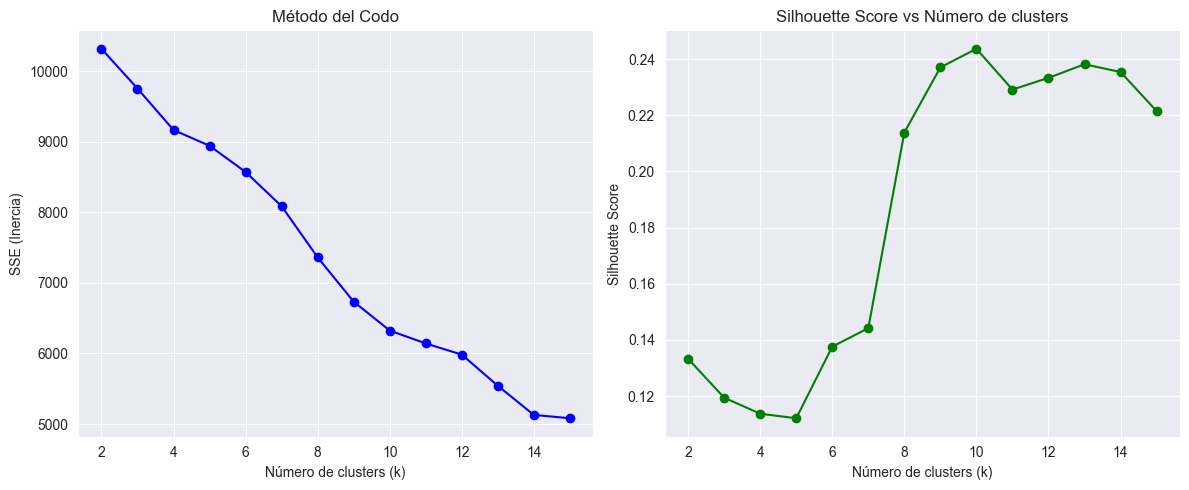

In [34]:
def evaluate_clustering_quality(X, max_k=15):
    """
    Aplica codificación, escalado y calcula el número óptimo de clusters con SSE y Silhouette.

    Parámetros:
    - X: DataFrame de características
    - y: (opcional) Serie objetivo (no se usa aquí pero se puede guardar para futuro uso)
    - max_k: máximo número de clusters a evaluar
    """
    print("Codificando y escalando los datos...")
    # One-hot encoding
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Escalado
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    sse = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)

    print(f"Evaluando calidad de clustering para k = 2 a {max_k}...")
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        sse.append(kmeans.inertia_)

        labels = kmeans.labels_
        silhouette = silhouette_score(X_scaled, labels)
        silhouette_scores.append(silhouette)

    # Gráficos
    plt.figure(figsize=(12, 5))

    # Elbow plot (SSE)
    plt.subplot(1, 2, 1)
    plt.plot(K_range, sse, 'bo-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('SSE (Inercia)')
    plt.title('Método del Codo')

    # Silhouette plot
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, 'go-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Número de clusters')

    plt.tight_layout()
    plt.show()

evaluate_clustering_quality(X, max_k=15)

Codificando y escalando los datos...
Evaluando HDBSCAN para min_cluster_size en [5, 10, 15, 20, 25, 30]...


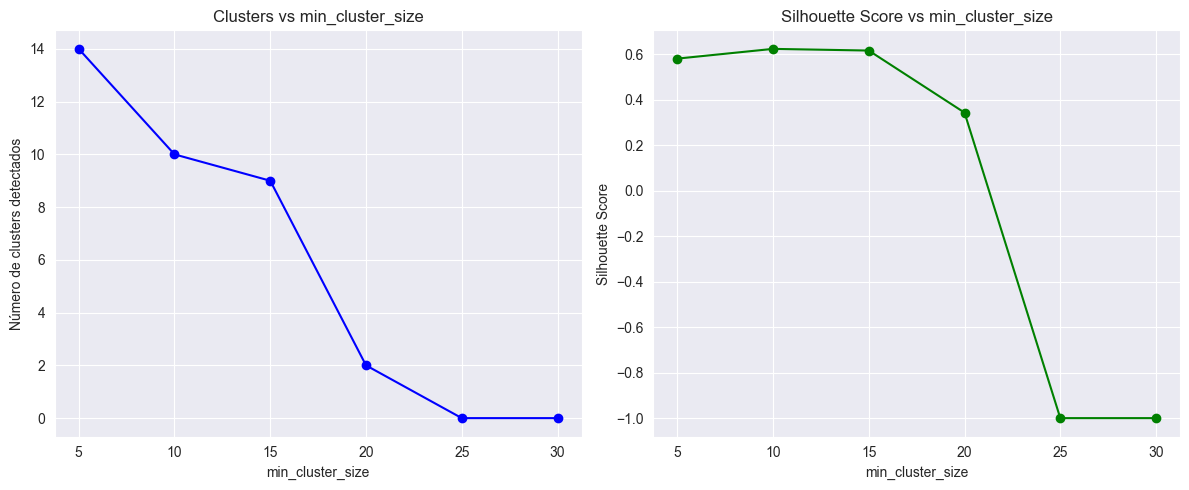

In [35]:
def evaluate_hdbscan_clustering(X, min_cluster_range=range(5, 31, 5)):
    """
    Codifica, escala y evalúa clustering con HDBSCAN para distintos min_cluster_size.

    Parámetros:
    - X: DataFrame de características.
    - min_cluster_range: rango de valores de min_cluster_size a probar.
    """
    print("Codificando y escalando los datos...")
    X_encoded = pd.get_dummies(X, drop_first=True)
    X_scaled = StandardScaler().fit_transform(X_encoded)

    silhouette_scores = []
    num_clusters_list = []

    print(f"Evaluando HDBSCAN para min_cluster_size en {list(min_cluster_range)}...")
    for min_cluster_size in min_cluster_range:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        labels = clusterer.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        num_clusters_list.append(n_clusters)

        # Evitar silhouette si sólo hay un cluster válido
        if n_clusters > 1:
            mask = labels != -1
            score = silhouette_score(X_scaled[mask], labels[mask])
        else:
            score = -1  # Valor indicativo de que no se pudo calcular

        silhouette_scores.append(score)

    # Gráficos
    plt.figure(figsize=(12, 5))

    # Número de clusters encontrados
    plt.subplot(1, 2, 1)
    plt.plot(min_cluster_range, num_clusters_list, 'bo-')
    plt.xlabel('min_cluster_size')
    plt.ylabel('Número de clusters detectados')
    plt.title('Clusters vs min_cluster_size')

    # Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(min_cluster_range, silhouette_scores, 'go-')
    plt.xlabel('min_cluster_size')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs min_cluster_size')

    plt.tight_layout()
    plt.show()


evaluate_hdbscan_clustering(X, min_cluster_range=range(5, 31, 5))

Durante el análisis de clustering, se evaluó la estructura interna de los datos utilizando dos enfoques distintos: KMeans, un algoritmo de particionamiento clásico, y HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise), un método más avanzado basado en densidad, debido a la grafica de T-sne, donde se mustra mejor la densidad de los puntos en el espacio. El objetivo era identificar posibles agrupaciones naturales dentro de los datos que pudieran ser incorporadas como grupos en el proceso de validación cruzada (StratifiedGroupKFold), permitiendo un control más granular del entrenamiento y mitigando riesgos como el data leakage y el overfitting.

En primer lugar, se aplicó KMeans evaluando diferentes números de clusters mediante la métrica del coeficiente de Silhouette, que mide la coherencia interna de cada grupo en relación con los demás. Los resultados indicaron que el número óptimo de clusters, sin ser excesivamente elevado, se sitúa en torno a 10. Sin embargo, este número relativamente alto sugiere que los datos no presentan segmentaciones naturales claras o bien definidas. Es decir, no existen patrones distintivos que permitan identificar con facilidad grupos internamente homogéneos y bien separados entre sí, lo cual limita la utilidad práctica de esta agrupación.

Como segunda alternativa, se empleó HDBSCAN, un algoritmo que no requiere especificar el número de clusters de antemano y que es especialmente útil para detectar estructuras complejas en conjuntos de datos ruidosos(motivo de elección), aunque no es en este caso, ya que previamente no se indentificaron outliers dentro del dataset, o de alta dimensionalidad. A diferencia de KMeans, HDBSCAN puede identificar puntos como ruido (es decir, no asignables a ningún cluster), lo cual resulta valioso cuando se sospecha que los datos no se distribuyen uniformemente. Pese a su mayor flexibilidad y sensibilidad a la estructura de densidad, los resultados tampoco evidenciaron la existencia de agrupaciones robustas o de valor analítico claro para este caso.

En conjunto, aunque la visualización bidimensional de los datos no sugería la posibilidad de cierta estructura latente, el análisis cuantitativo mediante clustering verifica que no existen segmentos definidos ni patrones clave lo suficientemente fuertes como para ser aprovechados como grupos en una validación cruzada estratificada por grupos. Por lo tanto, se concluye que este enfoque no proporciona valor añadido en este contexto concreto, y que será necesario explorar otras estrategias alternativas para abordar la complejidad del problema y estructurar el entrenamiento del modelo de forma eficaz.